In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from statsmodels.api import OLS, add_constant

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv("data/fixed_data.csv")
data

,AUN_SUM,HEALTH,K6SCMON,Treatment,Post,AGE2,IRSEX,INCOME,IRMARIT,SERVICE,CG30EST,AL30EST,IRHHSIZ2,NOBOOKY2,COCFLAG,COCYR,EDUCCAT2,JBSTATR2,TXEVER,TXYREVER
0,0.0,3.0,9.0,1,1,0.666667,2,1.000000,4,2.0,0.0,0.0,0.8,0.0,1,0,0.75,0.0,1.0,1.0
1,0.0,5.0,0.0,0,1,0.333333,1,0.000000,4,1.0,0.0,0.0,0.2,0.0,0,0,0.25,6.0,1.0,1.0
2,0.0,5.0,4.0,1,1,0.333333,2,0.333333,4,2.0,0.0,0.0,0.4,0.0,0,0,1.00,0.0,1.0,1.0
3,0.0,3.0,0.0,0,1,0.666667,2,0.000000,1,2.0,0.0,0.0,1.0,0.0,0,0,0.25,8.0,1.0,1.0
4,0.0,3.0,3.0,0,1,0.333333,1,0.333333,4,2.0,0.0,0.0,0.6,0.0,0,0,0.75,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602944,0.0,4.0,2.0,1,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.8,0.0,0,0,0.75,3.0,1.0,1.0
602945,0.0,5.0,0.0,0,0,0.333333,2,0.333333,1,2.0,0.0,0.0,0.6,0.0,0,0,0.50,8.0,1.0,1.0
602946,0.0,4.0,0.0,1,0,0.666667,2,1.000000,1,2.0,0.0,0.0,0.4,0.0,0,0,0.75,0.0,1.0,1.0
602947,0.0,4.0,1.0,0,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.4,0.0,1,0,0.50,1.0,0.0,0.0


In [5]:
# 결과 변수 목록
numeric_outcomes = ["AUN_SUM", "HEALTH", "K6SCMON"]

# 결과 저장
results = {}

# 수치형 결과 변수 처리
for outcome in numeric_outcomes:
    print(f"Estimating effect for numeric outcome (DiD + Parametric): {outcome}")

    # 변수 설정 (전체 데이터 사용)
    Y = data[outcome]
    T = data["Treatment"]
    Post = data["Post"]  # DiD의 시간 변수
    X = data.drop(columns=["Treatment", "Post"] + numeric_outcomes)

    # 성향 점수 계산 (Propensity Score)
    prop_model = LogisticRegression()
    prop_model.fit(X, T)
    propensity_scores = prop_model.predict_proba(X)[:, 1]

    # 처치와 성향 점수 추가
    X_with_ps = X.copy()
    X_with_ps['Propensity'] = propensity_scores
    X_with_ps['Post'] = Post
    X_with_ps['Treatment_Post'] = T * Post

    # 회귀 분석 (OLS)
    X_ols = add_constant(X_with_ps[['Propensity', 'Post', 'Treatment_Post']])
    ols_model = OLS(Y, X_ols).fit()

    # ATE 추정
    ate = ols_model.params['Treatment_Post']
    ci = ols_model.conf_int().loc['Treatment_Post']

    # 결과 저장
    results[outcome] = {
        "ATE": ate,
        "CI": (ci[0], ci[1])
    }

    print(f"ATE for {outcome}: {ate}, CI: ({ci[0]}, {ci[1]})\\n")

# 최종 결과 출력
for outcome, result in results.items():
    print(f"Outcome: {outcome}, ATE: {result['ATE']}, CI: {result['CI']}")


Estimating effect for numeric outcome (DiD + Parametric): AUN_SUM
ATE for AUN_SUM: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)\n
Estimating effect for numeric outcome (DiD + Parametric): HEALTH
ATE for HEALTH: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)\n
Estimating effect for numeric outcome (DiD + Parametric): K6SCMON
ATE for K6SCMON: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)\n
Outcome: AUN_SUM, ATE: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)
Outcome: HEALTH, ATE: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)
Outcome: K6SCMON, ATE: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)


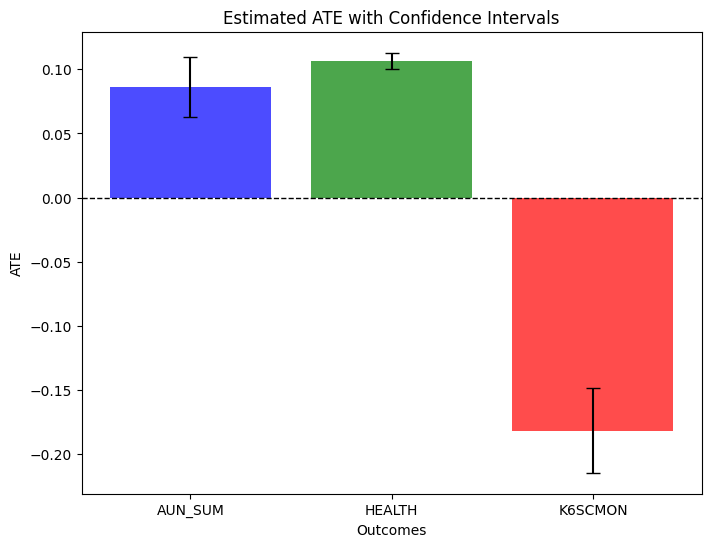

In [9]:
import matplotlib.pyplot as plt

# 시각화 데이터 준비
outcomes = list(results.keys())
ates = [results[outcome]["ATE"] for outcome in outcomes]
ci_lowers = [results[outcome]["CI"][0] for outcome in outcomes]
ci_uppers = [results[outcome]["CI"][1] for outcome in outcomes]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(outcomes, ates, yerr=[np.array(ates) - np.array(ci_lowers), np.array(ci_uppers) - np.array(ates)],
        capsize=5, color=['blue', 'green', 'red'], alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Outcomes")
plt.ylabel("ATE")
plt.title("Estimated ATE with Confidence Intervals")
plt.show()


Outcome: AUN_SUM
ATE (Average Treatment Effect): 0.0863
처치 후 AUN_SUM(방문 수)에 대한 평균적인 효과는 약 8.63% 증가로 해석됩니다.
CI (Confidence Interval): (0.0627, 0.1099)
신뢰구간이 0을 포함하지 않으므로 처치 효과가 통계적으로 유의미합니다.


Outcome: HEALTH
ATE: 0.1066
처치 후 HEALTH 점수는 평균적으로 10.66% 증가한 것으로 추정됩니다.
CI: (0.1003, 0.1129)
신뢰구간이 매우 좁으며, 처치 효과가 높은 신뢰도로 유의미하다는 것을 나타냅니다.


Outcome: K6SCMON
ATE: -0.1816
처치 후 K6SCMON(정신 건강 지표)은 평균적으로 18.16% 감소한 것으로 추정됩니다.
CI: (-0.2144, -0.1487)
신뢰구간이 0을 포함하지 않아 처치 효과가 통계적으로 유의미하며, 감소 효과가 뚜렷합니다.

# ATE Visualization

## ATE Before and After of Treatment

Analyzing outcome: AUN_SUM
Analyzing outcome: HEALTH
Analyzing outcome: K6SCMON


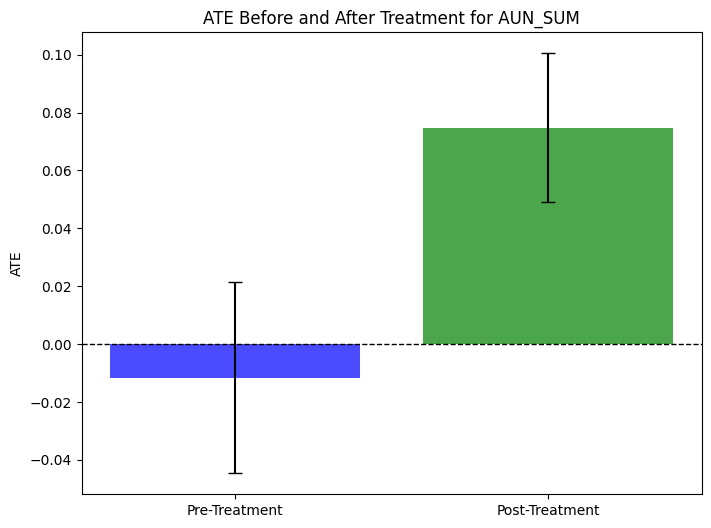

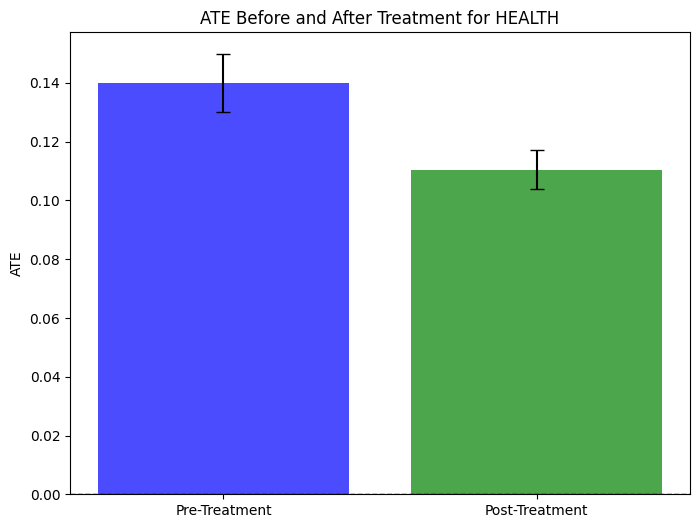

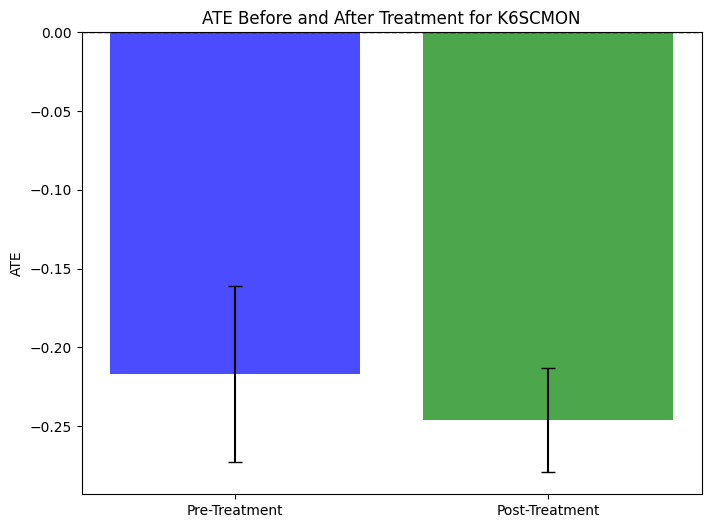

In [7]:
import matplotlib.pyplot as plt

# 처치 이전과 이후로 데이터 분리
pre_treatment_data = data[data["Post"] == 0]
post_treatment_data = data[data["Post"] == 1]

# ATE 결과 저장
time_results = {"Pre-Treatment": {}, "Post-Treatment": {}}

for outcome in numeric_outcomes:
    print(f"Analyzing outcome: {outcome}")

    for time, subset in zip(["Pre-Treatment", "Post-Treatment"], [pre_treatment_data, post_treatment_data]):
        Y = subset[outcome]
        T = subset["Treatment"]
        X = subset.drop(columns=["Treatment", "Post"] + numeric_outcomes)

        # 회귀 분석 (OLS)
        prop_model = LogisticRegression()
        prop_model.fit(X, T)
        propensity_scores = prop_model.predict_proba(X)[:, 1]

        X_with_ps = X.copy()
        X_with_ps['Propensity'] = propensity_scores
        X_with_ps['Treatment'] = T

        X_ols = add_constant(X_with_ps[['Propensity', 'Treatment']])
        ols_model = OLS(Y, X_ols).fit()

        ate = ols_model.params['Treatment']
        ci = ols_model.conf_int().loc['Treatment']

        time_results[time][outcome] = {"ATE": ate, "CI": (ci[0], ci[1])}

# 시각화
for outcome in numeric_outcomes:
    pre_ate = time_results["Pre-Treatment"][outcome]["ATE"]
    post_ate = time_results["Post-Treatment"][outcome]["ATE"]
    pre_ci = time_results["Pre-Treatment"][outcome]["CI"]
    post_ci = time_results["Post-Treatment"][outcome]["CI"]

    plt.figure(figsize=(8, 6))
    plt.bar(["Pre-Treatment", "Post-Treatment"], [pre_ate, post_ate],
            yerr=[[pre_ate - pre_ci[0], post_ate - post_ci[0]],
                  [pre_ci[1] - pre_ate, post_ci[1] - post_ate]],
            capsize=5, color=['blue', 'green'], alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"ATE Before and After Treatment for {outcome}")
    plt.ylabel("ATE")
    plt.show()


## Yearly ATE

In [21]:
data = pd.read_csv('data/merged_data (1).csv')
data = data.drop(columns=["QUESTID2", "AUUN_ANY", "AUUNCOST", "AUUNNCOV", "AUUNENUF", "PRVHLTIN", "GRPHLTIN", "AUPOPAMT"])  # ID 및 YEAR 변수 제거
data = data.dropna()
data = data.reset_index(drop=True)  # 인덱스 초기화
data

,AUN_SUM,HEALTH,K6SCMON,YEAR,Treatment,Post,AGE2,IRSEX,INCOME,IRMARIT,...,CG30EST,AL30EST,IRHHSIZ2,NOBOOKY2,COCFLAG,COCYR,EDUCCAT2,JBSTATR2,TXEVER,TXYREVER
0,0.0,3.0,9.0,2013,1,1,0.666667,2,1.000000,4,...,0.0,0.0,0.8,0.0,1,0,0.75,0.0,1.0,1.0
1,0.0,5.0,0.0,2013,0,1,0.333333,1,0.000000,4,...,0.0,0.0,0.2,0.0,0,0,0.25,6.0,1.0,1.0
2,0.0,5.0,4.0,2013,1,1,0.333333,2,0.333333,4,...,0.0,0.0,0.4,0.0,0,0,1.00,0.0,1.0,1.0
3,0.0,3.0,0.0,2013,0,1,0.666667,2,0.000000,1,...,0.0,0.0,1.0,0.0,0,0,0.25,8.0,1.0,1.0
4,0.0,3.0,3.0,2013,0,1,0.333333,1,0.333333,4,...,0.0,0.0,0.6,0.0,0,0,0.75,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602944,0.0,4.0,2.0,2009,1,0,0.333333,1,1.000000,4,...,0.0,0.0,0.8,0.0,0,0,0.75,3.0,1.0,1.0
602945,0.0,5.0,0.0,2009,0,0,0.333333,2,0.333333,1,...,0.0,0.0,0.6,0.0,0,0,0.50,8.0,1.0,1.0
602946,0.0,4.0,0.0,2009,1,0,0.666667,2,1.000000,1,...,0.0,0.0,0.4,0.0,0,0,0.75,0.0,1.0,1.0
602947,0.0,4.0,1.0,2009,0,0,0.333333,1,1.000000,4,...,0.0,0.0,0.4,0.0,1,0,0.50,1.0,0.0,0.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

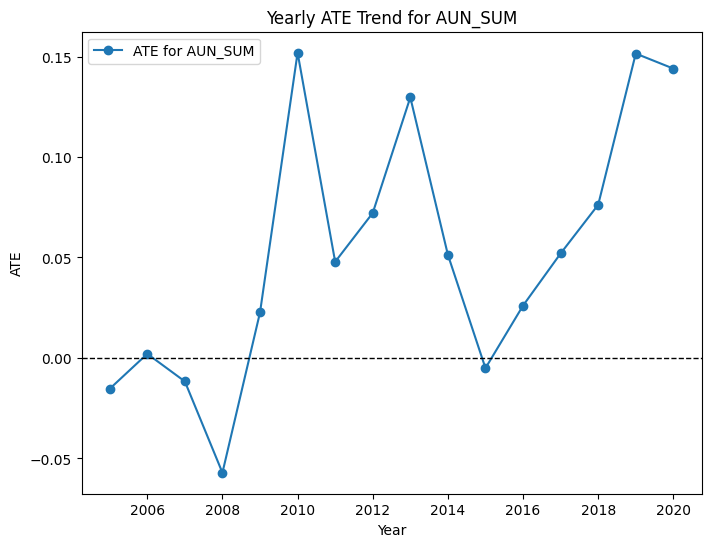

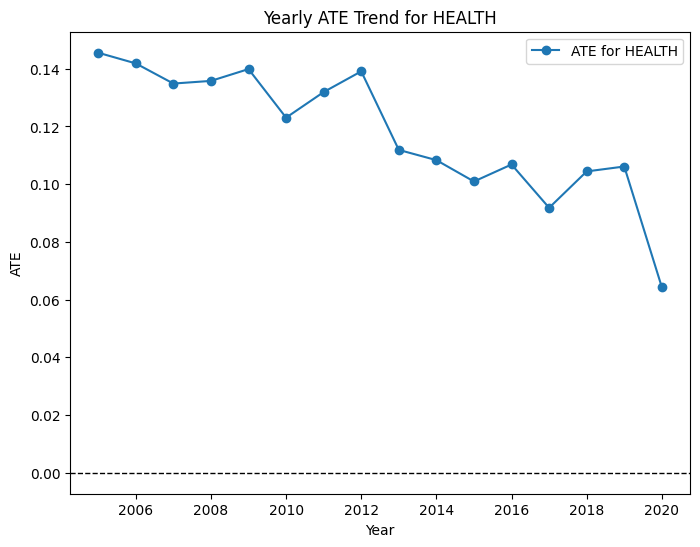

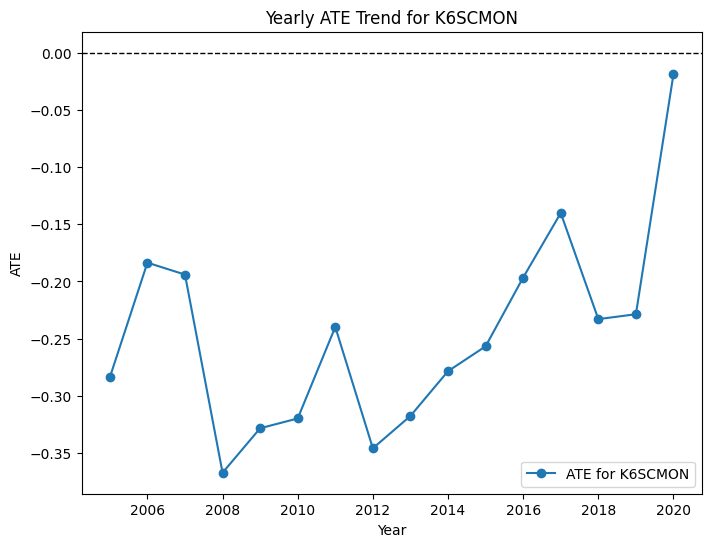

In [22]:
# 연도별 ATE 계산
time_trend_results = {}

for outcome in numeric_outcomes:
    time_trend_results[outcome] = []
    for year in sorted(data["YEAR"].unique()):
        yearly_data = data[data["YEAR"] == year]
        Y = yearly_data[outcome]
        T = yearly_data["Treatment"]
        X = yearly_data.drop(columns=["Treatment", "Post", "YEAR"] + numeric_outcomes)

        # 회귀 분석
        prop_model = LogisticRegression()
        prop_model.fit(X, T)
        propensity_scores = prop_model.predict_proba(X)[:, 1]

        X_with_ps = X.copy()
        X_with_ps['Propensity'] = propensity_scores
        X_with_ps['Treatment'] = T

        X_ols = add_constant(X_with_ps[['Propensity', 'Treatment']])
        ols_model = OLS(Y, X_ols).fit()

        ate = ols_model.params['Treatment']
        time_trend_results[outcome].append((year, ate))

# 시각화
for outcome, trend in time_trend_results.items():
    years, ates = zip(*trend)
    plt.figure(figsize=(8, 6))
    plt.plot(years, ates, marker='o', label=f"ATE for {outcome}")
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Yearly ATE Trend for {outcome}")
    plt.xlabel("Year")
    plt.ylabel("ATE")
    plt.legend()
    plt.show()


## Heterogeneous Treatment Effect(HTE)

In [25]:
data['INCOME'].unique() # 클수록 부자

array([1.        , 0.        , 0.33333333, 0.66666667])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Outcome: AUN_SUM
  INCOME Group 0.0: ATE=0.13420909979265613, CI=(0.07674666812067552, 0.19167153146463675)
  INCOME Group 0.3333333333333333: ATE=0.03999581544656, CI=(0.0046298260315218165, 0.07536180486159819)
  INCOME Group 0.6666666666666666: ATE=0.12125477466446852, CI=(0.06526143953546443, 0.1772481097934726)
  INCOME Group 1.0: ATE=0.1645233396186933, CI=(0.110566278113099, 0.21848040112428763)
Outcome: HEALTH
  INCOME Group 0.0: ATE=0.24329065906760863, CI=(0.22773575645994631, 0.25884556167527095)
  INCOME Group 0.3333333333333333: ATE=0.09591766954726798, CI=(0.08513322995613753, 0.10670210913839842)
  INCOME Group 0.6666666666666666: ATE=0.05986703766129401, CI=(0.04479504381867812, 0.0749390315039099)
  INCOME Group 1.0: ATE=0.09845712661699102, CI=(0.0863960328941298, 0.11051822033985224)
Outcome: K6SCMON
  INCOME Group 0.0: ATE=-0.17390645802600235, CI=(-0.2598162914850568, -0.08799662456694787)
  INCOME Group 0.3333333333333333: ATE=-0.13763713413486392, CI=(-0.19411646

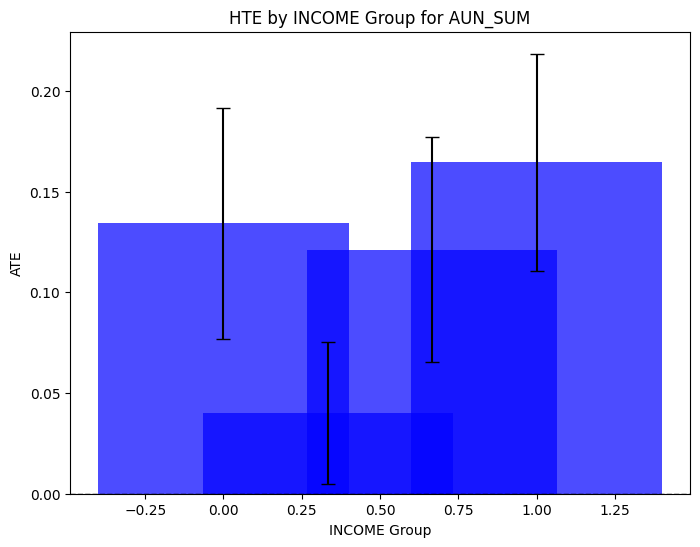

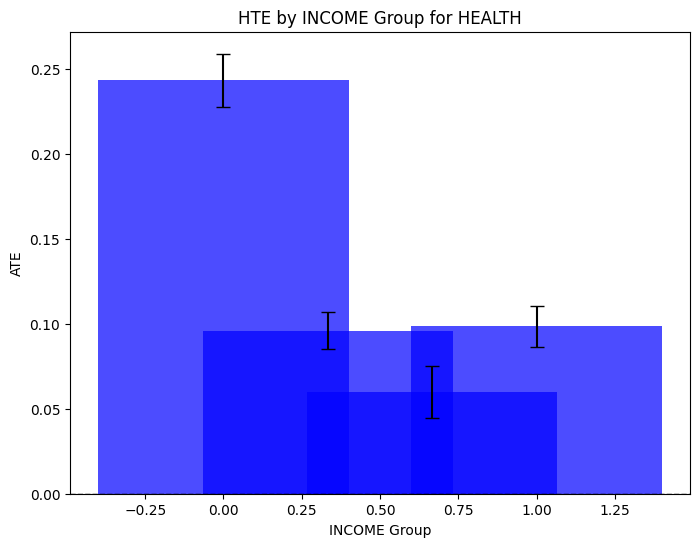

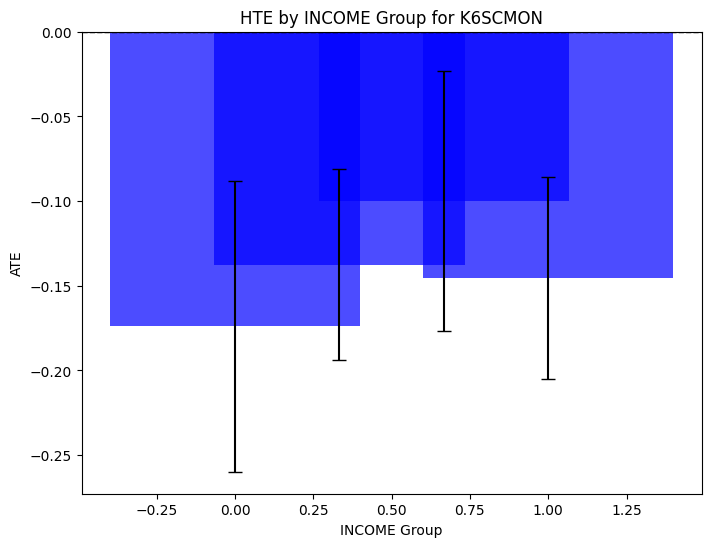

In [26]:
# INCOME 그룹별 ATE 결과 저장
income_ate_results = {}

for outcome in numeric_outcomes:
    income_ate_results[outcome] = {}
    for income_group in np.unique(data["INCOME"]):  # INCOME 그룹 반복
        group_data = data[data["INCOME"] == income_group]
        
        # 변수 설정
        Y = group_data[outcome]
        T = group_data["Treatment"]
        Post = group_data["Post"]
        X = group_data.drop(columns=["Treatment", "Post", "INCOME"] + numeric_outcomes)
        
        # 성향 점수 계산 (Propensity Score)
        prop_model = LogisticRegression()
        prop_model.fit(X, T)
        propensity_scores = prop_model.predict_proba(X)[:, 1]

        # 회귀 분석 (OLS)
        X_with_ps = X.copy()
        X_with_ps["Propensity"] = propensity_scores
        X_with_ps["Post"] = Post
        X_with_ps["Treatment_Post"] = T * Post

        X_ols = add_constant(X_with_ps[["Propensity", "Post", "Treatment_Post"]])
        ols_model = OLS(Y, X_ols).fit()

        # ATE 및 CI 저장
        ate = ols_model.params["Treatment_Post"]
        ci = ols_model.conf_int().loc["Treatment_Post"]
        income_ate_results[outcome][income_group] = {"ATE": ate, "CI": (ci[0], ci[1])}

# 결과 출력
for outcome, group_results in income_ate_results.items():
    print(f"Outcome: {outcome}")
    for income_group, result in group_results.items():
        print(f"  INCOME Group {income_group}: ATE={result['ATE']}, CI={result['CI']}")

# 시각화
import matplotlib.pyplot as plt

for outcome, group_results in income_ate_results.items():
    groups = list(group_results.keys())
    ates = [result["ATE"] for result in group_results.values()]
    ci_lowers = [result["CI"][0] for result in group_results.values()]
    ci_uppers = [result["CI"][1] for result in group_results.values()]
    
    # 막대 그래프 생성
    plt.figure(figsize=(8, 6))
    plt.bar(groups, ates, yerr=[np.array(ates) - np.array(ci_lowers), np.array(ci_uppers) - np.array(ates)],
            capsize=5, color="blue", alpha=0.7)
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"HTE by INCOME Group for {outcome}")
    plt.xlabel("INCOME Group")
    plt.ylabel("ATE")
    plt.show()


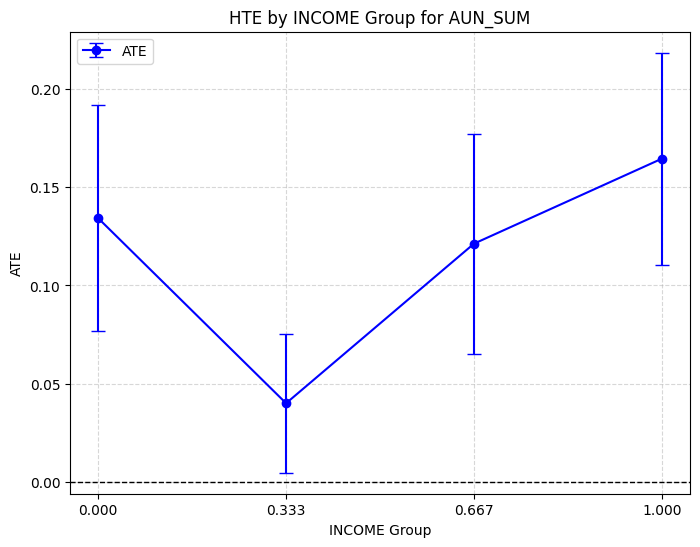

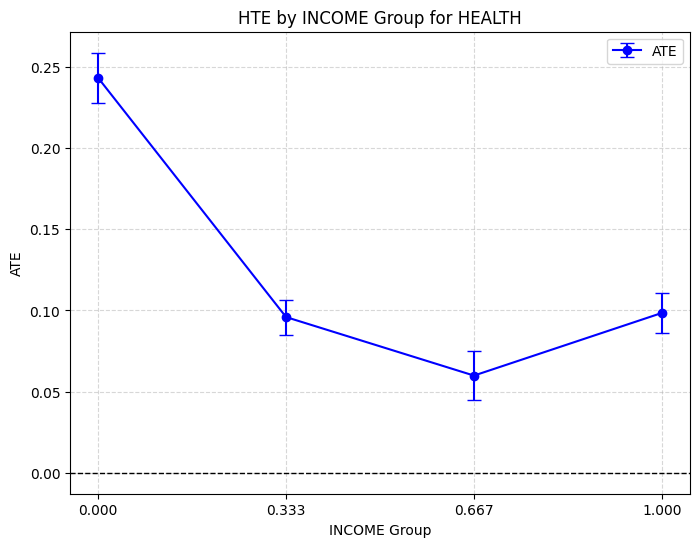

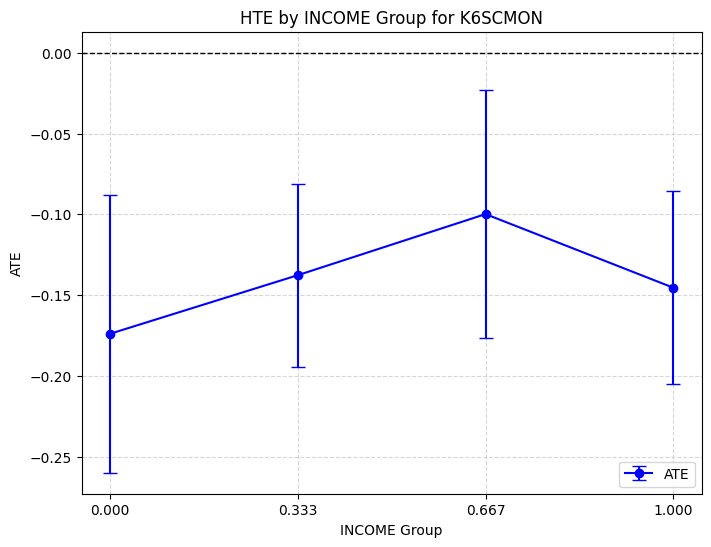

In [27]:
import matplotlib.pyplot as plt

# 시각화
for outcome, group_results in income_ate_results.items():
    groups = list(group_results.keys())
    ates = [result["ATE"] for result in group_results.values()]
    ci_lowers = [result["CI"][0] for result in group_results.values()]
    ci_uppers = [result["CI"][1] for result in group_results.values()]
    errors = [np.array(ates) - np.array(ci_lowers), np.array(ci_uppers) - np.array(ates)]

    plt.figure(figsize=(8, 6))
    plt.errorbar(groups, ates, yerr=errors, fmt='o', capsize=5, capthick=1, linestyle='-', color='blue', label='ATE')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"HTE by INCOME Group for {outcome}")
    plt.xlabel("INCOME Group")
    plt.ylabel("ATE")
    plt.xticks(groups)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()


Outcome: AUN_SUM (방문 수)
소득 그룹 0.0 (가장 낮은 소득): ATE는 0.134로 가장 높은 효과를 보였으며, 신뢰구간 CI=(0.0767, 0.1917)로 통계적으로 유의미합니다.
소득 그룹 0.333: ATE는 0.040으로 효과는 있지만 소득 그룹 0.0보다 작음.
소득 그룹 0.666: ATE는 0.121로 비교적 높은 처치 효과를 보였음.
소득 그룹 1.0 (가장 높은 소득): ATE는 0.165로 가장 높은 효과 중 하나로, CI=(0.1106, 0.2185)로 통계적으로 유의미.
해석: 소득이 낮거나 높은 그룹에서 처치 효과가 더 강하게 나타남.


Outcome: HEALTH (건강 상태)
소득 그룹 0.0: ATE는 0.243으로, 건강 상태 개선에 가장 큰 효과를 보임.
소득 그룹 0.333: ATE는 0.096으로 중간 정도의 효과를 나타냄.
소득 그룹 0.666: ATE는 0.060으로 처치 효과가 감소.
소득 그룹 1.0: ATE는 0.098로 건강 상태 개선에 소득 그룹 0.333과 유사한 효과를 보임.
해석: 낮은 소득 그룹(0.0)에서 건강 상태 개선 효과가 가장 강함.


Outcome: K6SCMON (정신 건강 상태)
소득 그룹 0.0: ATE는 -0.174로, 정신 건강 상태가 가장 크게 악화됨.
소득 그룹 0.333: ATE는 -0.138로 소득 그룹 0.0과 유사한 감소 효과.
소득 그룹 0.666: ATE는 -0.100으로 감소 효과가 상대적으로 약화됨.
소득 그룹 1.0: ATE는 -0.145로 정신 건강 상태 악화가 소득 그룹 0.333보다 약간 낮음.
해석: 전반적으로 처치 후 정신 건강 상태가 낮은 소득 그룹에서 더 크게 악화됨.

# Can we trust the results?

## What if we add noise

In [36]:
# 결과 변수 목록
numeric_outcomes = ["AUN_SUM", "HEALTH", "K6SCMON"]

# 결과 저장
results = {}

# 수치형 결과 변수 처리
for outcome in numeric_outcomes:
    print(f"Estimating effect for numeric outcome (DiD + Parametric): {outcome}")

    # 변수 설정 (전체 데이터 사용)
    Y = data[outcome]
    T = data["Treatment"]
    Post = data["Post"]  # DiD의 시간 변수
    X = data.drop(columns=["Treatment", "Post", "YEAR"] + numeric_outcomes)

    # 성향 점수 계산 (Propensity Score)
    prop_model = LogisticRegression()
    prop_model.fit(X, T)
    propensity_scores = prop_model.predict_proba(X)[:, 1]

    # 처치와 성향 점수 추가
    X_with_ps = X.copy()
    X_with_ps['Propensity'] = propensity_scores
    X_with_ps['Post'] = Post
    X_with_ps['Treatment_Post'] = T * Post

    # 회귀 분석 (OLS)
    X_ols = add_constant(X_with_ps[['Propensity', 'Post', 'Treatment_Post']])
    ols_model = OLS(Y, X_ols).fit()

    # ATE 추정
    ate = ols_model.params['Treatment_Post']
    ci = ols_model.conf_int().loc['Treatment_Post']

    # 결과 저장
    results[outcome] = {
        "ATE": ate,
        "CI": (ci[0], ci[1])
    }

    print(f"ATE for {outcome}: {ate}, CI: ({ci[0]}, {ci[1]})\\n")

# 최종 결과 출력
for outcome, result in results.items():
    print(f"Outcome: {outcome}, ATE: {result['ATE']}, CI: {result['CI']}")


Estimating effect for numeric outcome (DiD + Parametric): AUN_SUM
ATE for AUN_SUM: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)\n
Estimating effect for numeric outcome (DiD + Parametric): HEALTH
ATE for HEALTH: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)\n
Estimating effect for numeric outcome (DiD + Parametric): K6SCMON
ATE for K6SCMON: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)\n
Outcome: AUN_SUM, ATE: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)
Outcome: HEALTH, ATE: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)
Outcome: K6SCMON, ATE: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)


In [37]:
# 노이즈 추가하여 강건성 확인
noise_results = {}
np.random.seed(42)

print("\nPerforming sensitivity analysis with added noise...")

for outcome in numeric_outcomes:
    print(f"Analyzing noise impact on outcome: {outcome}")

    # 변수 설정 (전체 데이터 사용)
    Y_noisy = data[outcome] + np.random.normal(0, 0.1, size=data.shape[0])  # 결과 변수에 노이즈 추가
    T = data["Treatment"]
    Post = data["Post"]  # DiD의 시간 변수
    X_noisy = X + np.random.normal(0, 0.05, size=X.shape)  # 공변량에 노이즈 추가

    # 성향 점수 계산 (Propensity Score)
    prop_model_noisy = LogisticRegression()
    prop_model_noisy.fit(X_noisy, T)
    propensity_scores_noisy = prop_model_noisy.predict_proba(X_noisy)[:, 1]

    # 처치와 성향 점수 추가
    X_with_ps_noisy = X_noisy.copy()
    X_with_ps_noisy['Propensity'] = propensity_scores_noisy
    X_with_ps_noisy['Post'] = Post
    X_with_ps_noisy['Treatment_Post'] = T * Post

    # 회귀 분석 (OLS)
    X_ols_noisy = add_constant(X_with_ps_noisy[['Propensity', 'Post', 'Treatment_Post']])
    ols_model_noisy = OLS(Y_noisy, X_ols_noisy).fit()

    # ATE 추정
    ate_noisy = ols_model_noisy.params['Treatment_Post']
    ci_noisy = ols_model_noisy.conf_int().loc['Treatment_Post']

    # 결과 저장
    noise_results[outcome] = {
        "ATE": ate_noisy,
        "CI": (ci_noisy[0], ci_noisy[1])
    }

    print(f"ATE with noise for {outcome}: {ate_noisy}, CI: ({ci_noisy[0]}, {ci_noisy[1]})\n")

# 노이즈 추가 결과 출력
for outcome, result in noise_results.items():
    print(f"Outcome with noise: {outcome}, ATE: {result['ATE']}, CI: {result['CI']}")



Performing sensitivity analysis with added noise...
Analyzing noise impact on outcome: AUN_SUM
ATE with noise for AUN_SUM: 0.09051842119855852, CI: (0.06693571457114901, 0.11410112782596803)

Analyzing noise impact on outcome: HEALTH
ATE with noise for HEALTH: 0.1123913014084768, CI: (0.10606882334762432, 0.11871377946932926)

Analyzing noise impact on outcome: K6SCMON
ATE with noise for K6SCMON: -0.18535877480797788, CI: (-0.2181496145292725, -0.15256793508668326)

Outcome with noise: AUN_SUM, ATE: 0.09051842119855852, CI: (0.06693571457114901, 0.11410112782596803)
Outcome with noise: HEALTH, ATE: 0.1123913014084768, CI: (0.10606882334762432, 0.11871377946932926)
Outcome with noise: K6SCMON, ATE: -0.18535877480797788, CI: (-0.2181496145292725, -0.15256793508668326)


노이즈를 추가했음에도 결과의 통계적 유의성은 유지되었습니다. 이는 모델이 노이즈에 대해 비교적 강건하다는 것을 나타냅니다.

HEALTH 변수의 ATE와 CI는 노이즈를 추가한 후에도 안정적이고 유의미한 결과를 보입니다. 이는 처치가 HEALTH에 지속적으로 긍정적인 영향을 미치고 있음을 나타냅니다.

K6SCMON 변수의 음의 ATE는 처치 후 부정적인 영향을 나타내며, 이는 통계적으로 유의미합니다. 결과는 강건성을 유지하고 있습니다.

In [40]:
data.columns

Index(['AUN_SUM', 'HEALTH', 'K6SCMON', 'YEAR', 'Treatment', 'Post', 'AGE2',
       'IRSEX', 'INCOME', 'IRMARIT', 'SERVICE', 'CG30EST', 'AL30EST',
       'IRHHSIZ2', 'NOBOOKY2', 'COCFLAG', 'COCYR', 'EDUCCAT2', 'JBSTATR2',
       'TXEVER', 'TXYREVER'],
      dtype='object')

## Robustness Check

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.utils import resample
import numpy as np
import pandas as pd
from statsmodels.api import add_constant

data = pd.read_csv("data/fixed_data.csv")
data

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,AUN_SUM,HEALTH,K6SCMON,Treatment,Post,AGE2,IRSEX,INCOME,IRMARIT,SERVICE,CG30EST,AL30EST,IRHHSIZ2,NOBOOKY2,COCFLAG,COCYR,EDUCCAT2,JBSTATR2,TXEVER,TXYREVER
0,0.0,3.0,9.0,1,1,0.666667,2,1.000000,4,2.0,0.0,0.0,0.8,0.0,1,0,0.75,0.0,1.0,1.0
1,0.0,5.0,0.0,0,1,0.333333,1,0.000000,4,1.0,0.0,0.0,0.2,0.0,0,0,0.25,6.0,1.0,1.0
2,0.0,5.0,4.0,1,1,0.333333,2,0.333333,4,2.0,0.0,0.0,0.4,0.0,0,0,1.00,0.0,1.0,1.0
3,0.0,3.0,0.0,0,1,0.666667,2,0.000000,1,2.0,0.0,0.0,1.0,0.0,0,0,0.25,8.0,1.0,1.0
4,0.0,3.0,3.0,0,1,0.333333,1,0.333333,4,2.0,0.0,0.0,0.6,0.0,0,0,0.75,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602944,0.0,4.0,2.0,1,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.8,0.0,0,0,0.75,3.0,1.0,1.0
602945,0.0,5.0,0.0,0,0,0.333333,2,0.333333,1,2.0,0.0,0.0,0.6,0.0,0,0,0.50,8.0,1.0,1.0
602946,0.0,4.0,0.0,1,0,0.666667,2,1.000000,1,2.0,0.0,0.0,0.4,0.0,0,0,0.75,0.0,1.0,1.0
602947,0.0,4.0,1.0,0,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.4,0.0,1,0,0.50,1.0,0.0,0.0


In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import resample
import numpy as np
import pandas as pd
from statsmodels.api import add_constant

# Robustness 결과 저장
robustness_results = {}

# 샘플링 크기 (전체 데이터의 80%)
sample_size = int(len(data) * 0.8)

# 수치형 결과 변수 처리
for outcome in numeric_outcomes:
    print(f"Robustness Check for numeric outcome: {outcome}")

    # 변수 설정 (전체 데이터 사용)
    Y = data[outcome]
    T = data["Treatment"]
    Post = data["Post"]  # DiD의 시간 변수
    X = data.drop(columns=["Treatment", "Post"] + numeric_outcomes)

    # Bootstrap 결과 저장
    bootstrap_ates = []

    # Bootstrap 반복
    for i in range(100):  # 100번 반복
        # 샘플링 재구성 (Bootstrapping)
        sampled_data = resample(data, n_samples=sample_size, random_state=i)
        Y_sampled = sampled_data[outcome]
        T_sampled = sampled_data["Treatment"]
        Post_sampled = sampled_data["Post"]
        X_sampled = sampled_data.drop(columns=["Treatment", "Post"] + numeric_outcomes)

        # 성향 점수 계산 (LogisticRegression)
        prop_model = LogisticRegression()
        prop_model.fit(X_sampled, T_sampled)
        propensity_scores = prop_model.predict_proba(X_sampled)[:, 1]

        # 결과 모델 설정 (LinearRegression)
        result_model = LinearRegression()

        # 처치와 성향 점수 추가
        X_with_ps = X_sampled.copy()
        X_with_ps['Propensity'] = propensity_scores
        X_with_ps['Post'] = Post_sampled
        X_with_ps['Treatment_Post'] = T_sampled * Post_sampled

        # 회귀 분석 (OLS)
        X_ols = add_constant(X_with_ps[['Propensity', 'Post', 'Treatment_Post']])
        result_model.fit(X_ols, Y_sampled)

        # ATE 저장
        bootstrap_ates.append(result_model.coef_[-1])  # Treatment_Post의 계수 저장

    # ATE 및 CI 계산
    ate_mean = np.mean(bootstrap_ates)
    ci_lower, ci_upper = np.percentile(bootstrap_ates, [2.5, 97.5])

    # 결과 저장
    robustness_results[outcome] = {
        "ATE": ate_mean,
        "CI": (ci_lower, ci_upper)
    }

    print(f"ATE for {outcome}: {ate_mean}, CI: ({ci_lower}, {ci_upper})\n")

# 최종 Robustness 결과 출력
for outcome, result in robustness_results.items():
    print(f"Outcome: {outcome}, ATE: {result['ATE']}, CI: {result['CI']}")


Robustness Check for numeric outcome: AUN_SUM
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

ATE for AUN_SUM: 0.08646370932162716, CI: (0.057228424108832936, 0.11148805860558623)

Robustness Check for numeric outcome: HEALTH


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

ATE for HEALTH: 0.10684954095515081, CI: (0.09965422475852222, 0.11369533346145458)

Robustness Check for numeric outcome: K6SCMON


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

ATE for K6SCMON: -0.18049424403894965, CI: (-0.2184412636673633, -0.1381843791440181)

Outcome: AUN_SUM, ATE: 0.08646370932162716, CI: (0.057228424108832936, 0.11148805860558623)
Outcome: HEALTH, ATE: 0.10684954095515081, CI: (0.09965422475852222, 0.11369533346145458)
Outcome: K6SCMON, ATE: -0.18049424403894965, CI: (-0.2184412636673633, -0.1381843791440181)


부트스트랩 한 결과, 로버스트 체크 결과가 신뢰구간이 더 크지만, 모든 변수에서 신뢰구간이 ATE 값을 포함하고 있으며, 이는 부트스트랩 샘플링 과정에서 추정된 처치 효과가 강건하고 통계적으로 유의미하다는 것을 보여줍니다.